# DL vs ARDL

Aim of this notebook is to test the new DL and ARDL models coded into utils, and choose a model for the study.

In [1]:
from utils.models import *

In [2]:
env()

--------- Dependencies ---------
python: 3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:25:23) [MSC v.1916 64 bit (AMD64)]
numpy: 1.21.0
pandas: 1.2.4
matplotlib: 3.4.2
statsmodels: 0.13.0


## 1. Context

In [3]:
wti = load('data/WTI.csv').pct_change().dropna()
c1 = clean_series('contract_1', wti)

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf

C:\Users\ztche\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


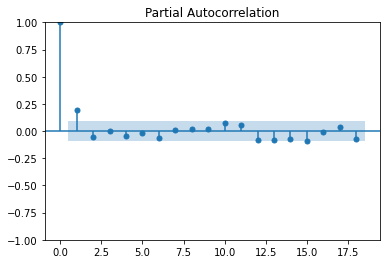

In [5]:
t = plot_pacf(c1.contract_1, lags=18, alpha=.05)

Clearly WTI returns is serially correlated at the AR(1) level. This raises the question of whether to use an autoregressive impulse response function - ARDL - or the simpler DL function.

## 2. DL

For the following let $WTI$ be the nominal price of WTI crude, $S$ be the shock variable and $I$ the value of the the index used. The DL specification is given by:

$\%\Delta{WTI}_t = \alpha + \sum_{p=0}^{12} \beta_p S_{t-p} + \epsilon_t$

where

$S_t = \%\Delta{I_t} - \%\Delta{(\frac{1}{12}\sum_{j=0}^{11} I_{t-j})}$

The average magnitude of $\%\Delta{WTI}$ at month $p$ after the shock is thus given by $\beta_p$. We will use VIX as our shock variable for this comparison.

\* Adapted from Kilian, L. (2008). A Comparison of the Effects of Exogenous Oil Supply Shocks on Output and Inflation in the G7 Countries. *Journal of the European Economic Association*, 6(1), pp 78-121.

In [6]:
vix = load('data/VIX.csv')
vix_shock = calc_shock('VIX', vix)

In [7]:
dl_model = DL('contract_1', 'VIX', c1.join(vix_shock))
dl_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             contract_1   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.219
Date:                Sun, 06 Feb 2022   Prob (F-statistic):              0.264
Time:                        14:08:51   Log-Likelihood:                -500.25
No. Observations:                 358   AIC:                             1029.
Df Residuals:                     344   BIC:                             1083.
Df Model:                          13                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0123      0.056      0.219      0.827      -0.098       0.122
VIX-lag0      -0.0883      0.063     -1.404      0.161      -0.212       0.035
VIX-lag1      -0.2000      0.068     -2.924      0.004      -0.335      -0.065
VIX-lag2      -0.0556      0.060     -0.934      0.351      -0.173       0.062
VIX-lag3      -0.0831      0.057     -1.447      0.149      -0.196       0.030
VIX-lag4      -0.0412      0.059     -0.695      0.488      -0.158       0.076
VIX-lag5       0.0528      0.065      0.815      0.415      -0.075       0.180
VIX-lag6       0.0417      0.061      0.687      0.493      -0.078       0.161
VIX-lag7       0.0021      0.059      0.035      0.972      -0.115       0.119
VIX-lag8      -0.0439      0.058     -0.758      0.449      -0.158       0.070
VIX-lag9      -0.0524      0.057     -0.927      0.354      -0.164       0.059
VIX-lag10     -0.0182      0.058     -0.316      0.752      -0.132       0.095
VIX-lag11     -0.0569      0.061     -0.936      0.350      -0.177       0.063
VIX-lag12     -0.0092      0.063     -0.145      0.885      -0.133       0.115
==============================================================================
Omnibus:                        6.256   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                4.126
Skew:                          -0.091   Prob(JB):                        0.127
Kurtosis:                       2.507   Cond. No.                         2.56
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

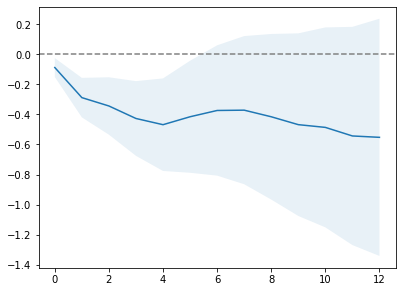

In [8]:
dl_model.plot()

C:\Users\ztche\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


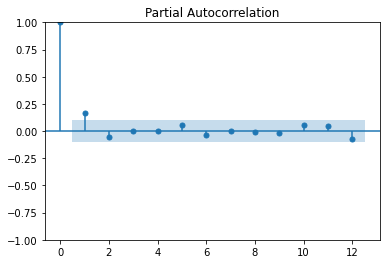

In [9]:
t = plot_pacf(dl_model.model.resid, lags=12)

As anticipated, residuals are serially correlated.

## 3. ARDL

The ARDL specification is given by:

$\%\Delta{WTI}_t = \alpha + \sum_{i=1}^{a} \gamma_{i} \%\Delta{WTI}_{t-i} + \sum_{j=0}^{b} \phi_{j} S_{t-j} + \epsilon_t$

where

$a + b = 13$

Shock variable is calculated the same as with the DL specification. To get the response function, we must now simulate the response from $\gamma$ and $\phi$

\* Adapted from Kilian, L. (2008). A Comparison of the Effects of Exogenous Oil Supply Shocks on Output and Inflation in the G7 Countries. *Journal of the European Economic Association*, 6(1), pp 78-121.

In [10]:
ardl_model = ARDL('contract_1', 'VIX', c1.join(vix_shock))
ardl_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             contract_1   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.974
Date:                Sun, 06 Feb 2022   Prob (F-statistic):             0.0221
Time:                        14:08:52   Log-Likelihood:                -496.43
No. Observations:                 359   AIC:                             1021.
Df Residuals:                     345   BIC:                             1075.
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0081      0.052      0.156      0.876      -0.094       0.110
contract_1-lag1     0.1711      0.052      3.285      0.001       0.069       0.274
VIX-lag0           -0.0906      0.064     -1.410      0.159      -0.217       0.036
VIX-lag1           -0.1879      0.066     -2.839      0.005      -0.318      -0.058
VIX-lag2           -0.0286      0.062     -0.462      0.644      -0.150       0.093
VIX-lag3           -0.0746      0.060     -1.237      0.217      -0.193       0.044
VIX-lag4           -0.0296      0.061     -0.487      0.627      -0.149       0.090
VIX-lag5            0.0599      0.068      0.887      0.376      -0.073       0.193
VIX-lag6            0.0353      0.058      0.606      0.545      -0.079       0.150
VIX-lag7           -0.0099      0.062     -0.160      0.873      -0.131       0.112
VIX-lag8           -0.0431      0.058     -0.747      0.456      -0.157       0.070
VIX-lag9           -0.0469      0.058     -0.809      0.419      -0.161       0.067
VIX-lag10          -0.0068      0.055     -0.123      0.902      -0.116       0.102
VIX-lag11          -0.0539      0.056     -0.961      0.337      -0.164       0.056
==============================================================================
Omnibus:                        8.582   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                4.781
Skew:                           0.014   Prob(JB):                       0.0916
Kurtosis:                       2.435   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

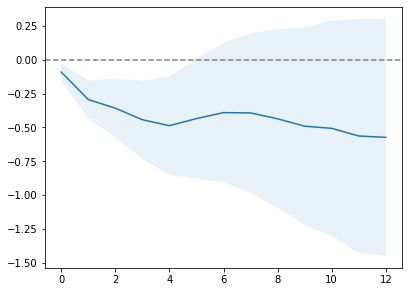

In [11]:
ardl_model.plot()

C:\Users\ztche\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


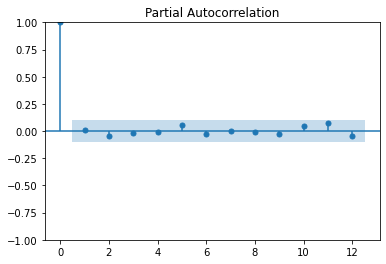

In [12]:
t = plot_pacf(ardl_model.model.resid, lags=12)

The ARDL model successsfully accounts for serial correlation of residuals.

## 4. Comp

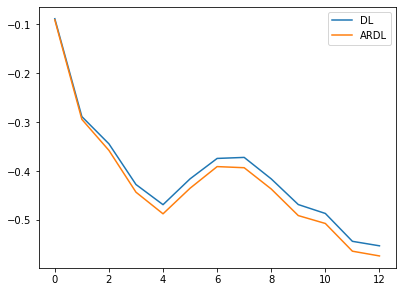

In [13]:
plt.figure(figsize=(6.4,4.8))
plt.plot(np.cumsum(dl_model.model.params[1:]), label='DL')
plt.plot(ardl_model.simulate_response(), label='ARDL')
plt.legend()

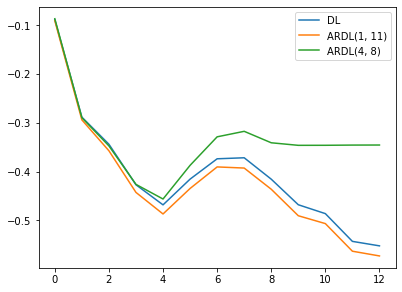

In [14]:
ardl_model2 = ARDL('contract_1', 'VIX', c1.join(vix_shock), lags=[4, 8])
plt.figure(figsize=(6.4,4.8))
plt.plot(np.cumsum(dl_model.model.params[1:]), label='DL')
plt.plot(ardl_model.simulate_response(), label='ARDL(1, 11)')
plt.plot(ardl_model2.simulate_response(), label='ARDL(4, 8)')
plt.legend()

It seems like there is only a marginal difference from using ARDL with the correct AR specification. Since our study will be looking to infer time-varying trend rather than predictive accuracy, we will use the DL specification for simplicity.